In [28]:
import numpy as np
from numba import jit
import pints
import pints.plot
import pints_smol_jit_num_clus_pro as toy
import matplotlib.pyplot as plt



Select the desired model, true parameters and time array.

Then simulate to get synthetic data

In [29]:

model = toy.SmolModel(None,None)


true_parameters = [0.0002, 0.0025, 500]


times = np.linspace(0, 97, 9700)

org_values = model.simulate(true_parameters, times)

print(org_values)

print(org_values.shape)


Init 1
[[5.00000000e+002 0.00000000e+000 0.00000000e+000 ... 0.00000000e+000
  0.00000000e+000 0.00000000e+000]
 [4.99500317e+002 2.62139880e-001 1.37561024e-004 ... 6.35986003e-319
  2.51973479e-322 0.00000000e+000]
 [4.99001370e+002 5.23506860e-001 5.49205579e-004 ... 2.89955856e-284
  3.04971525e-287 3.20351438e-290]
 ...
 [2.78359318e+000 2.84437375e+000 2.90570097e+000 ... 1.97133509e+001
  2.03015070e+001 2.09216123e+001]
 [2.77900802e+000 2.83988115e+000 2.90130497e+000 ... 1.97643931e+001
  2.03546617e+001 2.09769895e+001]
 [2.77442406e+000 2.83538944e+000 2.89690957e+000 ... 1.98155610e+001
  2.04079486e+001 2.10325060e+001]]
(9700, 100)


Perfect data

In [63]:
values = org_values
problem = pints.MultiOutputProblem(model, times, values)
log_likelihood_2 = pints.GaussianIntegratedLogUniformLogLikelihood(problem)
log_prior = pints.UniformLogPrior(
    [0.0001, 0.001, 100],
    [0.001, 0.01, 2000]
    )
log_posterior = pints.LogPosterior(log_likelihood_2, log_prior)
xs = [
    np.array(true_parameters) * 0.9,
    np.array(true_parameters) * 1.05,
    np.array(true_parameters) * 1.15,
]
ITERS = 10000
mcmc = pints.MCMCController(log_posterior, 3, xs, method=pints.SliceDoublingMCMC)
mcmc.set_max_iterations(ITERS)
chains = mcmc.run()
print(chains)

/var/folders/lt/9g_w308946v4x_5mqxc951qr0000gr/T/ipykernel_62564/1950585908.py:4: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  log_prior = pints.UniformLogPrior(


Using Slice Sampling - Doubling
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Time m:s
0     3       0:00.0
1     168     0:03.1
2     351     0:06.0
3     432     0:06.5
20    2076    0:15.9
40    3969    0:26.2
60    6009    0:37.3
80    8127    0:49.3
100   10182   1:00.6
120   12336   1:12.2
140   14484   1:24.0
160   16716   1:36.2
180   19089   1:49.6
200   21543   2:04.1
220   23781   2:19.4
240   26115   2:35.1
260   28647   2:51.7
280   31104   3:06.8
300   33504   3:21.3
320   35961   3:35.9
340   38469   3:50.7
360   41121   4:06.3
380   43812   4:22.6
400   46302   4:37.2
420   48963   4:53.0
440   51624   5:08.5
460   54300   5:24.6
480   56952   5:40.3
500   59730   5:56.8
520   62646   6:14.2
540   65427   6:30.6
560   68319   6:47.6
580   71184   7:04.4
600   73998   7:21.3
620   76836   7:38.0
640   79524   7:54.8
660   82458   8:11.3
680   85398   8:28.1
700   88338   8:44.7
720   91569   9:02.8
740   94470   9:19.4
760   97650   9:37.1
780   100623   9

In [64]:
from tabulate import tabulate
class MyMCMCSummary(pints.MCMCSummary):
    def __str__(self):
        """
        Prints posterior summaries for all parameters to the console, including
        the parameter name, posterior mean, posterior std deviation, the
        2.5%, 25%, 50%, 75% and 97.5% posterior quantiles, rhat, effective
        sample size (ess) and ess per second of run time.
        """
        if self._summary_str is None:
            headers = [
                'param', 'mean', 'std.',
                '2.5%', '25%', '50%', '75%', '97.5%',
                'rhat', 'ess']
            if self._time is not None:
                headers.append('ess per sec.')

            self._summary_str = tabulate(
                self._summary_list,
                headers=headers,
                numalign='left',
                floatfmt='.3g',
            )

        return self._summary_str
    


8000


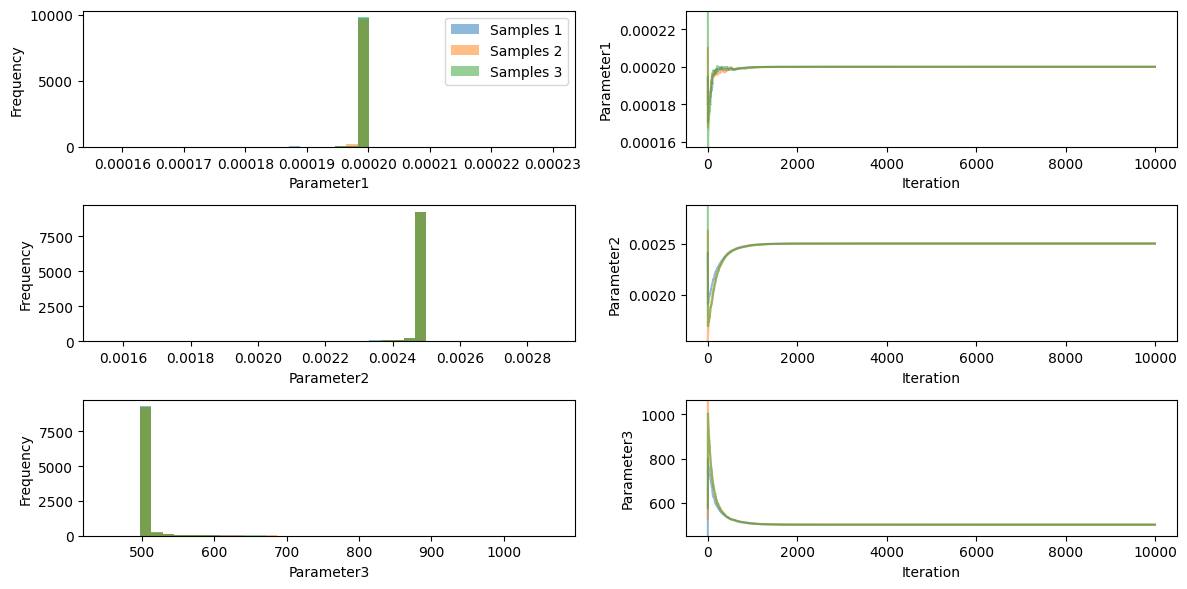

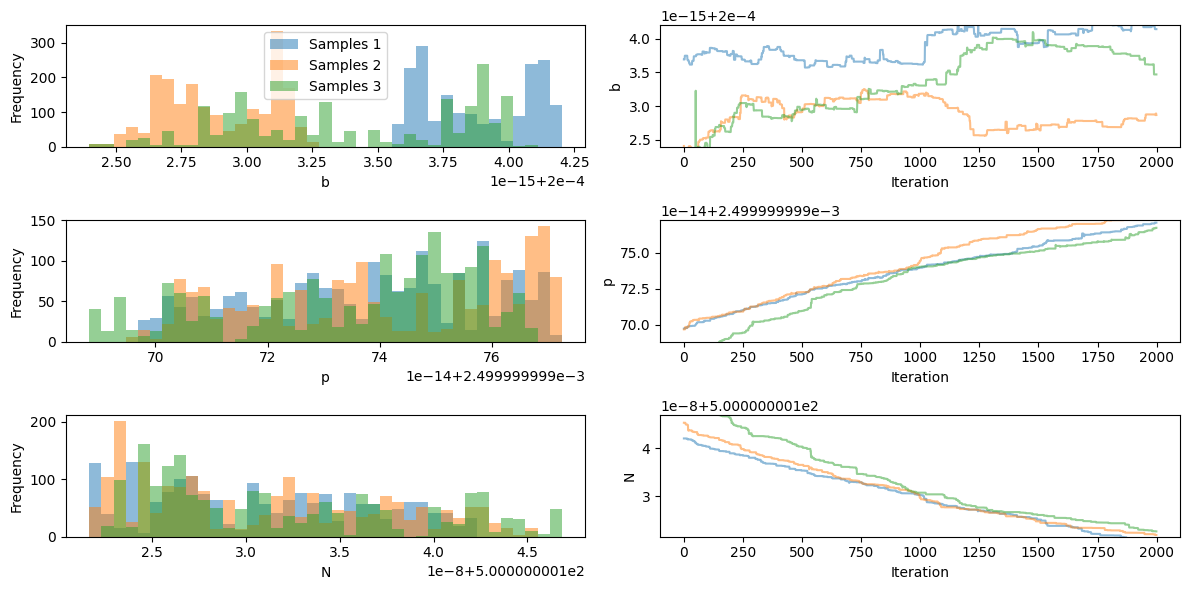

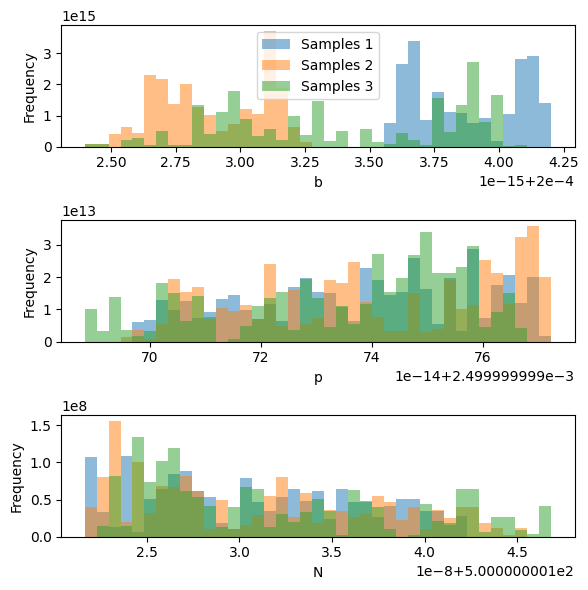

<class '__main__.MyMCMCSummary'>
param    mean    std.      2.5%    25%     50%     75%     97.5%    rhat    ess    ess per sec.
-------  ------  --------  ------  ------  ------  ------  -------  ------  -----  --------------
b        0.0002  1.37e-09  0.0002  0.0002  0.0002  0.0002  0.0002   1.06    42.6   0.00196
p        0.0025  7.01e-08  0.0025  0.0025  0.0025  0.0025  0.0025   1.06    41.1   0.00189
N        500     0.0229    500     500     500     500     500      1.06    40.7   0.00187


In [93]:
parameter_names = ["b","p","N"]
ITERS=10000
print(int(4*ITERS/5))
pints.plot.trace(chains)
plt.savefig("perfect_data_full_distribution.png")
plt.show()

pints.plot.trace(chains[:,int(4*ITERS/5):, :], n_percentiles=95, parameter_names=parameter_names)
# plt.savefig("hist_only_perfect_data_full_distribution.png")
plt.show()

pints.plot.histogram(chains[:,int(4*ITERS/5):, :], kde=False, n_percentiles=95, parameter_names=parameter_names)
plt.savefig("hist_only_perfect_data_full_distribution.png")
plt.show()

parameter_names = ["b","p","N"]
results = MyMCMCSummary(chains=chains[:,int(1*ITERS/5):, :], time=mcmc.time(),
                            parameter_names = parameter_names)
print(type(results))
print(results)



[0.0002 0.0002 0.0002 ... 0.0002 0.0002 0.0002]


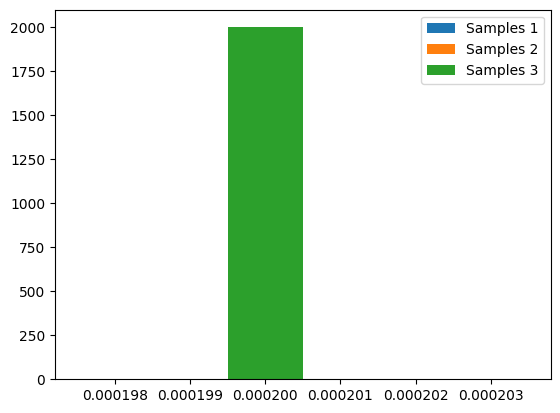

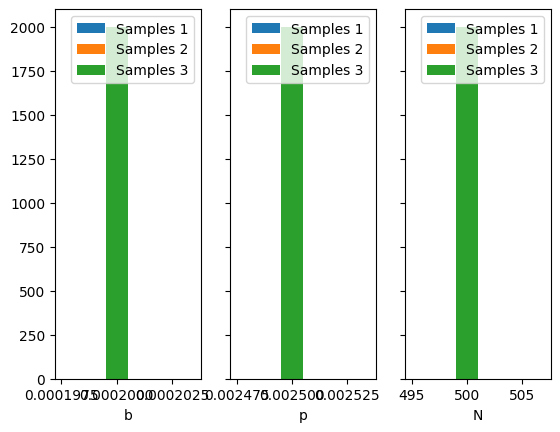

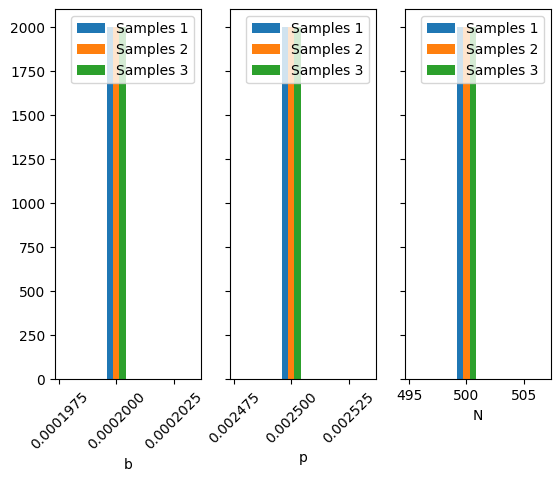

In [112]:
# print(np.shape(chains[:,int(4*ITERS/5):, :]))
ITERS = 10000

print(chains[:,int(4*ITERS/5):, 0][0])

# plt.hist(chains[:,int(4*ITERS/5):, 0])

plt.hist(chains[:,int(4*ITERS/5):, 0][0], bins=[0.0001975,0.0001985,0.0001995,0.0002005,0.0002015,0.0002025,0.0002035])
plt.hist(chains[:,int(4*ITERS/5):, 0][1], bins=[0.0001975,0.0001985,0.0001995,0.0002005,0.0002015,0.0002025,0.0002035])
plt.hist(chains[:,int(4*ITERS/5):, 0][2], bins=[0.0001975,0.0001985,0.0001995,0.0002005,0.0002015,0.0002025,0.0002035])
plt.legend(["Samples 1", "Samples 2", "Samples 3"])
# plt.savefig("hist_only_perfect_data_full_distribution_manual.png")
plt.show()



# Create two subplots and unpack the output array immediately
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)
ax1.hist(chains[:,int(4*ITERS/5):, 0][0], bins=[0.0001975,0.0001985,0.0001995,0.0002005,0.0002015,0.0002025,0.0002035])
ax1.hist(chains[:,int(4*ITERS/5):, 0][1], bins=[0.0001975,0.0001985,0.0001995,0.0002005,0.0002015,0.0002025,0.0002035])
ax1.hist(chains[:,int(4*ITERS/5):, 0][2], bins=[0.0001975,0.0001985,0.0001995,0.0002005,0.0002015,0.0002025,0.0002035])
ax1.set_xlabel('b')
ax1.legend(["Samples 1", "Samples 2", "Samples 3"])
ax2.hist(chains[:,int(4*ITERS/5):, 1][0], bins=[0.002475,0.002485,0.002495,0.002505,0.002515,0.002525,0.002535])
ax2.hist(chains[:,int(4*ITERS/5):, 1][1], bins=[0.002475,0.002485,0.002495,0.002505,0.002515,0.002525,0.002535])
ax2.hist(chains[:,int(4*ITERS/5):, 1][2], bins=[0.002475,0.002485,0.002495,0.002505,0.002515,0.002525,0.002535])
ax2.set_xlabel('p')
ax2.legend(["Samples 1", "Samples 2", "Samples 3"])
ax3.hist(chains[:,int(4*ITERS/5):, 2][0], bins=[495,497,499,501,503,505,507])
ax3.hist(chains[:,int(4*ITERS/5):, 2][1], bins=[495,497,499,501,503,505,507])
ax3.hist(chains[:,int(4*ITERS/5):, 2][2], bins=[495,497,499,501,503,505,507])
ax3.set_xlabel('N')
ax3.legend(["Samples 1", "Samples 2", "Samples 3"])
plt.show()


f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)
ax1.hist([chains[:,int(4*ITERS/5):, 0][0], chains[:,int(4*ITERS/5):, 0][1], chains[:,int(4*ITERS/5):, 0][2]], 
         bins=[0.0001975,0.0001985,0.0001995,0.0002005,0.0002015,0.0002025,0.0002035])
ax1.set_xlabel('b')
ax1.legend(["Samples 1", "Samples 2", "Samples 3"])
ax2.hist([chains[:,int(4*ITERS/5):, 1][0], chains[:,int(4*ITERS/5):, 1][1], chains[:,int(4*ITERS/5):, 1][2]], 
         bins=[0.002475,0.002485,0.002495,0.002505,0.002515,0.002525,0.002535])
ax2.set_xlabel('p')
ax2.legend(["Samples 1", "Samples 2", "Samples 3"])
ax3.hist([chains[:,int(4*ITERS/5):, 2][0], chains[:,int(4*ITERS/5):, 2][1], chains[:,int(4*ITERS/5):, 2][2]], 
         bins=[495,497,499,501,503,505,507])
ax3.set_xlabel('N')
ax3.legend(["Samples 1", "Samples 2", "Samples 3"])
plt.savefig("hist_only_perfect_data_full_distribution_manual.png")
plt.show()




Multiplicative noise

In [33]:
noise = 1
values = org_values *(1 + noise * np.random.normal(0, 1, org_values.shape))
problem = pints.MultiOutputProblem(model, times, values)
log_likelihood_2 = pints.GaussianIntegratedLogUniformLogLikelihood(problem)
log_prior = pints.UniformLogPrior(
    [0.0001, 0.001, 100],
    [0.001, 0.01, 2000]
    )
log_posterior = pints.LogPosterior(log_likelihood_2, log_prior)
xs = [
    np.array(true_parameters) * 0.9,
    np.array(true_parameters) * 1.05,
    np.array(true_parameters) * 1.15,
]
ITERS = 2000
mcmc = pints.MCMCController(log_posterior, 3, xs, method=pints.SliceDoublingMCMC)
mcmc.set_max_iterations(ITERS)
chains = mcmc.run()
print(chains)

Using Slice Sampling - Doubling
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Time m:s
0     3       0:00.0


/var/folders/lt/9g_w308946v4x_5mqxc951qr0000gr/T/ipykernel_62564/3381684360.py:5: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  log_prior = pints.UniformLogPrior(


1     177     0:02.5
2     336     0:04.1
3     405     0:04.5
20    2319    0:15.4
40    4833    0:28.9
60    7320    0:43.3
80    9906    0:57.5
100   12495   1:11.9
120   14985   1:25.3
140   17751   1:40.2
160   20358   1:54.2
180   23148   2:09.2
200   25728   2:22.9
220   28524   2:38.0
240   30984   2:51.2
260   33654   3:05.6
280   36357   3:20.1
300   38982   3:34.2
320   41772   3:49.6
340   44466   4:04.8
360   47247   4:19.9
380   49818   4:34.7
400   52542   4:48.9
420   55134   5:02.1
440   57939   5:17.2
460   60498   5:30.6
480   63180   5:44.4
500   65793   5:57.5
520   68625   6:12.2
540   71337   6:26.2
560   74037   6:40.8
580   76755   6:56.5
600   79497   7:11.0
620   82341   7:25.7
640   85194   7:40.6
660   87846   7:54.5
680   90498   8:08.3
700   93078   8:21.5
720   95610   8:34.6
740   98340   8:48.6
760   101091   9:02.8
780   103875   9:17.2
800   106593   9:33.6
820   109254   9:50.3
840   112032  10:06.1
860   114744  10:21.2
880   117333  10:35.4
900   

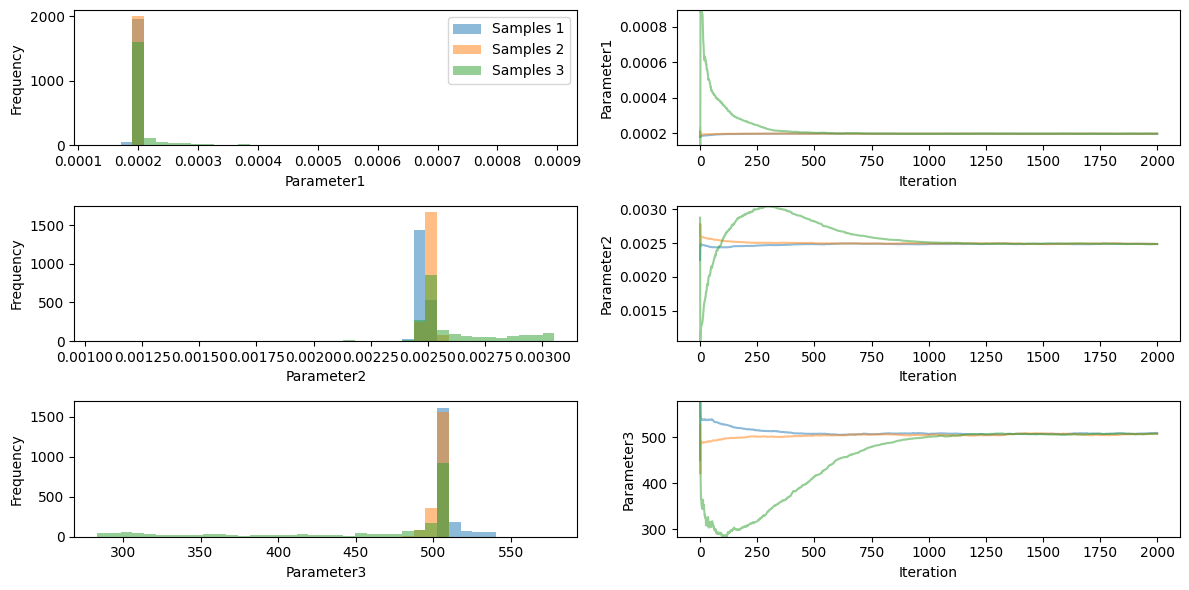

<class '__main__.MyMCMCSummary'>
param    mean      std.     2.5%      25%       50%       75%       97.5%     rhat    ess    ess per sec.
-------  --------  -------  --------  --------  --------  --------  --------  ------  -----  --------------
b        0.000198  3.2e-07  0.000197  0.000198  0.000198  0.000198  0.000199  1.09    33.6   0.0244
p        0.00249   4.7e-06  0.00248   0.00249   0.00249   0.00249   0.0025    1.24    29.3   0.0213
N        506       1.5      502       506       507       507       508       1.2     20.8   0.0152


In [34]:
pints.plot.trace(chains)
plt.savefig("noisy_data_multiplicative_full_distribution.png")
plt.show()

parameter_names = ["b","p","N"]
results = MyMCMCSummary(chains=chains[:,int(ITERS/2):, :], time=mcmc.time(),
                            parameter_names = parameter_names)
print(type(results))
print(results)



Additive noise

In [53]:
noise = 1
values = org_values + noise * np.random.normal(0, 0.25, org_values.shape)
problem = pints.MultiOutputProblem(model, times, values)
log_likelihood_2 = pints.GaussianIntegratedLogUniformLogLikelihood(problem)
log_prior = pints.UniformLogPrior(
    [0.0001, 0.001, 100],
    [0.001, 0.01, 2000]
    )
log_posterior = pints.LogPosterior(log_likelihood_2, log_prior)
xs = [
    np.array(true_parameters) * 0.9,
    np.array(true_parameters) * 1.05,
    np.array(true_parameters) * 1.15,
]
ITERS = 2000
mcmc = pints.MCMCController(log_posterior, 3, xs, method=pints.SliceDoublingMCMC)
mcmc.set_max_iterations(ITERS)
chains_3 = mcmc.run()

print(chains_3)

/var/folders/lt/9g_w308946v4x_5mqxc951qr0000gr/T/ipykernel_62564/3265528936.py:5: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  log_prior = pints.UniformLogPrior(


Using Slice Sampling - Doubling
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Time m:s
0     3       0:00.0
1     156     0:03.5
2     351     0:09.5
3     483     0:10.5
20    2082    0:20.6
40    4227    0:33.5
60    6153    0:45.1
80    8358    1:00.3
100   10494   1:11.5
120   12597   1:22.9
140   14760   1:34.2
160   16857   1:45.1
180   19212   1:57.9
200   21531   2:10.5
220   23988   2:24.4
240   26235   2:37.2
260   28653   2:49.8
280   31014   3:03.5
300   33405   3:15.7
320   35793   3:27.7
340   38124   3:41.0
360   40440   3:53.2
380   42939   4:05.8
400   45321   4:17.9
420   47841   4:31.0
440   50202   4:43.8
460   52491   4:55.9
480   55608   5:11.5
500   59001   5:29.0
520   62463   5:47.9
540   66024   6:07.4
560   69612   6:25.7
580   72981   6:43.2
600   76299   7:00.4
620   79722   7:18.2
640   83268   7:36.3
660   86901   7:54.8
680   90279   8:11.9
700   93783   8:30.7
720   97167   8:49.0
740   100512   9:06.4
760   104043   9:24.3
780   107520  

1500.0


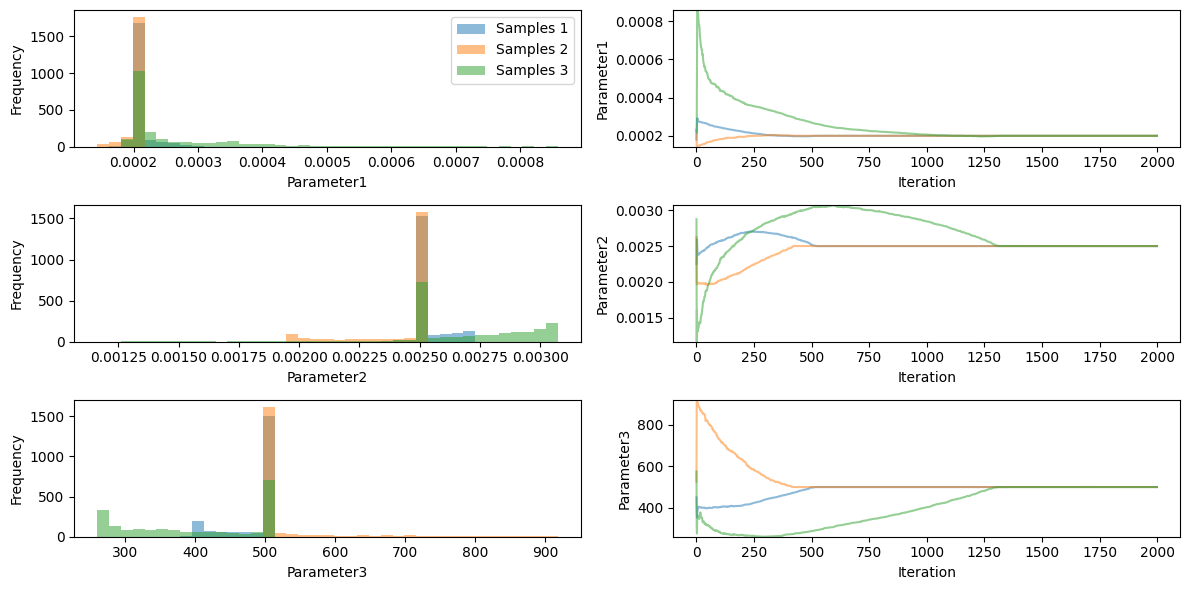

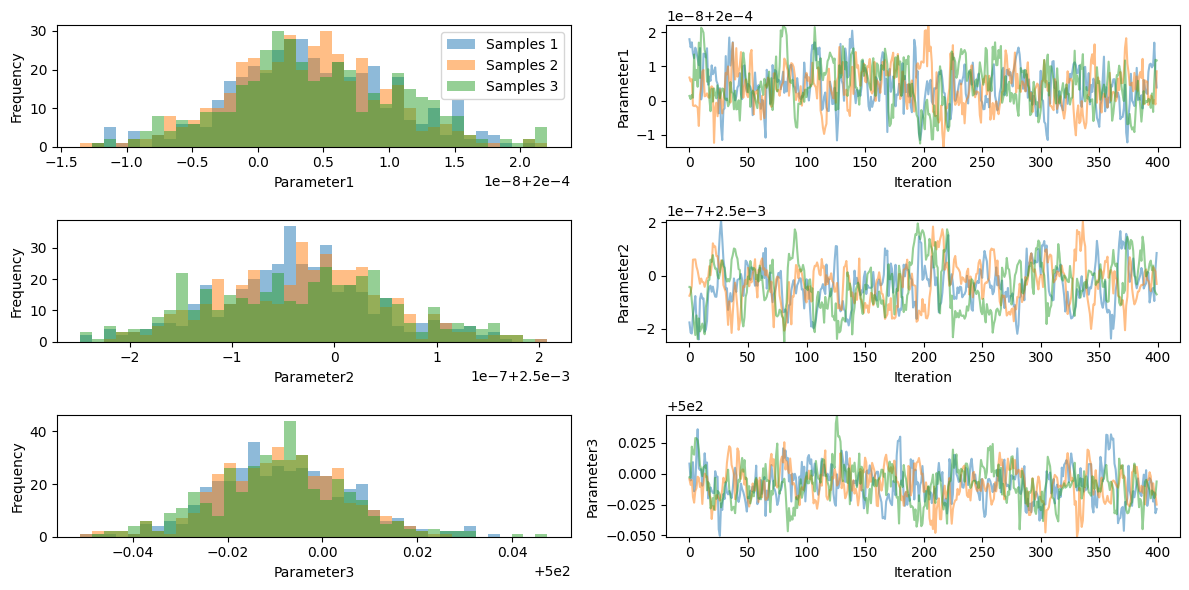

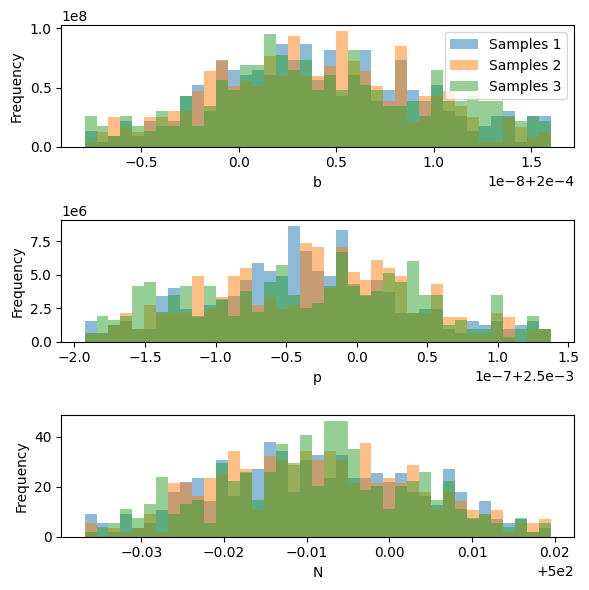

<class '__main__.MyMCMCSummary'>
param    mean    std.      2.5%    25%     50%     75%     97.5%    rhat    ess    ess per sec.
-------  ------  --------  ------  ------  ------  ------  -------  ------  -----  --------------
b        0.0002  6.34e-09  0.0002  0.0002  0.0002  0.0002  0.0002   1       161    0.0074
p        0.0025  8.61e-08  0.0025  0.0025  0.0025  0.0025  0.0025   1       130    0.00598
N        500     0.0142    500     500     500     500     500      1       184    0.00849


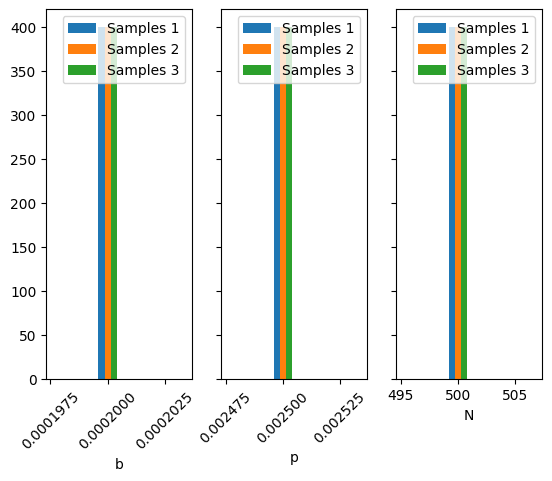

In [115]:
ITERS = 2000
print(3*ITERS/4)

pints.plot.trace(chains_3)
plt.savefig("noisy_data_additive_full_distribution.png")
plt.show()

pints.plot.trace(chains_3[:,int(4*ITERS/5):, :])
# plt.savefig("noisy_data_additive_full_distribution.png")
plt.show()

pints.plot.histogram(chains_3[:,int(4*ITERS/5):, :], kde=False, n_percentiles=95, parameter_names=parameter_names)
plt.savefig("hist_only_noisy_data_additive_full_distribution.png")
plt.show()

parameter_names = ["b","p","N"]
results = MyMCMCSummary(chains=chains_3[:,int(3*ITERS/4):, :], time=mcmc.time(),
                            parameter_names = parameter_names)
print(type(results))
print(results)


f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)
ax1.hist([chains_3[:,int(4*ITERS/5):, 0][0], chains_3[:,int(4*ITERS/5):, 0][1], chains_3[:,int(4*ITERS/5):, 0][2]], 
         bins=[0.0001975,0.0001985,0.0001995,0.0002005,0.0002015,0.0002025,0.0002035])
ax1.set_xlabel('b')
ax1.legend(["Samples 1", "Samples 2", "Samples 3"])
ax2.hist([chains_3[:,int(4*ITERS/5):, 1][0], chains_3[:,int(4*ITERS/5):, 1][1], chains_3[:,int(4*ITERS/5):, 1][2]], 
         bins=[0.002475,0.002485,0.002495,0.002505,0.002515,0.002525,0.002535])
ax2.set_xlabel('p')
ax2.legend(["Samples 1", "Samples 2", "Samples 3"])
ax3.hist([chains_3[:,int(4*ITERS/5):, 2][0], chains_3[:,int(4*ITERS/5):, 2][1], chains_3[:,int(4*ITERS/5):, 2][2]], 
         bins=[495,497,499,501,503,505,507])
ax3.set_xlabel('N')
ax3.legend(["Samples 1", "Samples 2", "Samples 3"])
plt.savefig("hist_only_noisy_data_additive_full_distribution_manual.png")
plt.show()

